# EnsCGP example: real data (`gv161`)

This notebook demonstrates an ensemble-approximated conditional Gaussian Process (**EnsCGP**) update on one real-data example.

## What you’ll do
1. Load:
   - Real MT data (`data/real/gv161/`): apparent resistivity and phase on the **observed** frequency grid.
   - Synthetic ensemble bank (`data/synthetic/ensemble_bank_small/`): resistivity models + MT responses on the **training** frequency grid (the grid used by the pretrained neural network).
2. Interpolate ensemble responses onto the **observed** frequency grid.
3. Select nearest neighbors (cosine distance) from the ensemble bank.
4. Run EnsCGP update on the observed band.
5. Forward-model the posterior resistivity ensemble on:
   - the **observed** grid (for plotting/diagnostics), and
   - the **training** grid (to feed the pretrained ResNet later).
6. Plot and save outputs under `outputs/enscgp/gv161/`.

> **Notes on units/conventions**
- Apparent resistivity is handled in **log space** (natural log).
- Phase is in **degrees**.
- When plotting MT responses, we plot vs **period** (`T = 1/f`).


In [1]:
# --- Imports & setup ---
from __future__ import annotations

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# If you run this from repo root, set repo = Path('.')
# If you run from examples/, set repo = Path('..')
repo = Path('..').resolve()  # <- assumes this notebook lives in examples/

real_dir = repo / 'data' / 'real' / 'gv161'
ens_dir  = repo / 'data' / 'synthetic' / 'ensemble_bank_small'

out_dir = repo / 'outputs' / 'enscgp' / 'gv161'
out_dir.mkdir(parents=True, exist_ok=True)

print('repo:', repo)
print('real_dir:', real_dir)
print('ens_dir:', ens_dir)
print('out_dir:', out_dir)


repo: /mnt/c/Users/jdkim/Documents/Research_Projects/1D_NPI/synt_1d_gabbs/mt_example_gabbs_valley/1d_final/synt_training_final/npi-mt
real_dir: /mnt/c/Users/jdkim/Documents/Research_Projects/1D_NPI/synt_1d_gabbs/mt_example_gabbs_valley/1d_final/synt_training_final/npi-mt/data/real/gv161
ens_dir: /mnt/c/Users/jdkim/Documents/Research_Projects/1D_NPI/synt_1d_gabbs/mt_example_gabbs_valley/1d_final/synt_training_final/npi-mt/data/synthetic/ensemble_bank_small
out_dir: /mnt/c/Users/jdkim/Documents/Research_Projects/1D_NPI/synt_1d_gabbs/mt_example_gabbs_valley/1d_final/synt_training_final/npi-mt/outputs/enscgp/gv161


## 1) Import project utilities

We import:
- IO helpers (`npi_mt.io`)
- EnsCGP workflow (`npi_mt.enscgp`)
- Forward batch evaluation (`npi_mt.forward`)

Because projects sometimes rename functions during cleanup, the import cell below includes a small **fallback** section that prints helpful diagnostics if an import fails.


In [2]:
# --- Project imports (with light fallback diagnostics) ---
try:
    from npi_mt.io import load_real_example, load_depths, load_ensemble_bank
except Exception as e:
    raise ImportError(
        'Could not import IO helpers from npi_mt.io. '
        'Check that src/npi_mt/io/__init__.py exports load_real_example, load_depths, load_ensemble_bank.'
    ) from e

try:
    from npi_mt.enscgp import (
        run_enscgp_update,
        NoiseModel,
        EnsCGPSolverConfig,
        NeighborConfig,
        MTEnsembleData,
    )
except Exception as e:
    raise ImportError(
        'Could not import EnsCGP components from npi_mt.enscgp. '
        'Check that src/npi_mt/enscgp/__init__.py exports run_enscgp_update and config dataclasses.'
    ) from e

# interpolation helper
try:
    from npi_mt.enscgp import interp_ensemble_to_freqs
    _HAS_INTERP_HELPER = True
except Exception:
    _HAS_INTERP_HELPER = False
    print('Warning: interp_ensemble_to_freqs not found in npi_mt.enscgp. '
          'Falling back to local interpolation implementation below.')

# Batch forward modeling helper (name may vary)
try:
    from npi_mt.mt1d import forward_ensemble
except Exception as e:
    raise ImportError(
        'Could not import forward_ensemble from npi_mt.mt1d. '
        'Check your forward module exports a batch forward helper.'
    ) from e


In [3]:
# --- Local fallback: interpolation helper (only used if package helper missing) ---
from scipy.interpolate import interp1d

def _interp_ensemble_to_freqs_local(freqs_src_hz, freqs_tgt_hz, log_app_src, phase_deg_src, kind='cubic'):
    freqs_src_hz = np.asarray(freqs_src_hz, float)
    freqs_tgt_hz = np.asarray(freqs_tgt_hz, float)

    log_fs = np.log10(freqs_src_hz)
    log_ft = np.log10(freqs_tgt_hz)

    log_app_src = np.asarray(log_app_src, float)
    phase_deg_src = np.asarray(phase_deg_src, float)

    f_app = interp1d(log_fs, log_app_src, kind=kind, axis=0, bounds_error=False, fill_value='extrapolate')
    log_app_tgt = f_app(log_ft)

    phase_rad = np.unwrap(np.deg2rad(phase_deg_src), axis=0)
    f_ph = interp1d(log_fs, phase_rad, kind=kind, axis=0, bounds_error=False, fill_value='extrapolate')
    phase_tgt = np.rad2deg(f_ph(log_ft))

    return log_app_tgt, phase_tgt


## 2) Load real data and the ensemble bank

Your repository data layout is:

```
data/
  real/gv161/
    app_res_ohm_m.txt
    phase_deg.txt
    freqs_hz.txt
    depths_m.txt

  synthetic/ensemble_bank_small/
    appres_ens.txt
    phase_ens.txt
    freqs_hz.txt
    depths_m.txt
    rho_ens.txt
```


In [4]:
# --- Load data ---
obs = load_real_example(real_dir)     # expected fields: freqs_hz, log_app_res, phase_deg
depths_m = load_depths(real_dir)      # interfaces: shape (Z+1,)
ens = load_ensemble_bank(ens_dir)     # expected: freqs_hz, log_app_res(F,N), phase_deg(F,N), log_rho(Z,N)

freqs_obs = obs.freqs_hz
freqs_train = ens.freqs_hz

periods_obs = 1.0 / freqs_obs
periods_train = 1.0 / freqs_train

Z, N = ens.log_rho.shape
print('Observed grid: F_obs =', freqs_obs.size)
print('Training grid: F_train =', freqs_train.size)
print('Ensemble: Z =', Z, 'N =', N)


Observed grid: F_obs = 20
Training grid: F_train = 23
Ensemble: Z = 89 N = 5000


## 3) Interpolate ensemble responses from training grid → observed grid

In [5]:
# --- Interpolate ensemble responses onto observed grid ---
if _HAS_INTERP_HELPER:
    ens_log_app_obs, ens_phase_obs = interp_ensemble_to_freqs(
        freqs_src_hz=freqs_train,
        freqs_tgt_hz=freqs_obs,
        log_appres_src=ens.log_app_res,
        phase_deg_src=ens.phase_deg,
        kind='cubic',
    )
else:
    ens_log_app_obs, ens_phase_obs = _interp_ensemble_to_freqs_local(
        freqs_src_hz=freqs_train,
        freqs_tgt_hz=freqs_obs,
        log_app_src=ens.log_app_res,
        phase_deg_src=ens.phase_deg,
        kind='cubic',
    )

ens_on_obs = MTEnsembleData(
    freqs_hz=freqs_obs,
    log_app_res=ens_log_app_obs,
    phase_deg=ens_phase_obs,
    log_rho=ens.log_rho,
)

print('ens_on_obs.log_app_res shape:', ens_on_obs.log_app_res.shape)
print('ens_on_obs.phase_deg shape:', ens_on_obs.phase_deg.shape)
print('ens_on_obs.log_rho shape:', ens_on_obs.log_rho.shape)


ens_on_obs.log_app_res shape: (20, 5000)
ens_on_obs.phase_deg shape: (20, 5000)
ens_on_obs.log_rho shape: (89, 5000)


## 4) Configure noise model, neighbor selection, and solver options

In [6]:
# --- Noise model and solver config ---
rel_err = 0.05

noise = NoiseModel(
    app_res_log_sigma=2.0 * rel_err,
    phase_deg_sigma=float(np.degrees(np.arctan(rel_err))),
)

neighbor_cfg = NeighborConfig(metric='cosine', n_neighbors=500)

solver_cfg = EnsCGPSolverConfig(
    damping=1.0,
    reg_eps=1e-12,
    perturb_observations=True,
)

print('noise:', noise)
print('neighbor_cfg:', neighbor_cfg)
print('solver_cfg:', solver_cfg)


noise: NoiseModel(app_res_log_sigma=0.1, phase_deg_sigma=2.862405226111748)
neighbor_cfg: NeighborConfig(metric='cosine', n_neighbors=500)
solver_cfg: EnsCGPSolverConfig(damping=1.0, reg_eps=1e-12, perturb_observations=True)


## 5) Run one EnsCGP update on the observed grid

In [7]:
# --- Run EnsCGP single-shot update ---
result = run_enscgp_update(
    obs=obs,
    ensemble=ens_on_obs,
    depths_m=depths_m,
    noise=noise,
    solver=solver_cfg,
    neighbor_cfg=neighbor_cfg,
    fwd_workers=4,
)

print('nRMS (mean prediction on obs band):', getattr(result, 'nrms_mean', None))
print('posterior log_rho shape:', result.log_rho_updated.shape)
print('posterior pred log_app_res (obs) shape:', result.log_app_res_updated.shape)
print('posterior pred phase (obs) shape:', result.phase_deg_updated.shape)
print('neighbor indices:', result.neighbor_indices.shape)


nRMS (mean prediction on obs band): 4.97632233283284
posterior log_rho shape: (89, 500)
posterior pred log_app_res (obs) shape: (20, 500)
posterior pred phase (obs) shape: (20, 500)
neighbor indices: (500,)


## 6) Forward-model posterior ensemble on the training grid

In [8]:
# --- Forward posterior ensemble on training grid ---
rho_post_lin = np.exp(result.log_rho_updated).T  # (N, Z)

app_train_lin, ph_train_deg = forward_ensemble(
    rho_ens_ohm_m=rho_post_lin,
    depth_interfaces_m=depths_m,
    freqs_hz=freqs_train,
    n_workers=4,
)

log_app_train = np.log(np.clip(app_train_lin.T, 1e-32, None))  # (F_train, N)
ph_train = ph_train_deg.T                                     # (F_train, N)

print('log_app_train shape:', log_app_train.shape)
print('ph_train shape:', ph_train.shape)


log_app_train shape: (23, 500)
ph_train shape: (23, 500)


## 7) Plotting utilities

In [9]:
def _depth_midpoints(depths_m: np.ndarray) -> np.ndarray:
    depths_m = np.asarray(depths_m, float)
    return 0.5 * (depths_m[:-1] + depths_m[1:])

def plot_resistivity_ensemble(log_rho_ZN, depths_m, title, savepath=None):
    z_mid = _depth_midpoints(depths_m)
    rho = np.exp(log_rho_ZN)
    rho_mean = np.exp(np.mean(log_rho_ZN, axis=1))

    plt.figure(figsize=(5, 8))
    plt.plot(rho, z_mid, color='gray', alpha=0.25, lw=0.8)
    plt.plot(rho_mean, z_mid, 'r-', lw=2, label='Mean')
    plt.gca().invert_yaxis()
    plt.xscale('log')
    plt.xlabel(r'Resistivity ($\Omega$m)')
    plt.ylabel('Depth (m)')
    plt.title(title)
    plt.grid(True, which='both', ls=':')
    plt.legend(loc='lower left')
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, bbox_inches='tight', dpi=200)
    plt.show()

def plot_mt_ensemble(periods_s, log_app_FN, phase_FN, obs_log_app, obs_phase, title, savepath=None):
    plt.figure(figsize=(18, 12))

    # Apparent resistivity
    plt.subplot(211)
    plt.plot(periods_s, np.exp(log_app_FN), color='gray', alpha=0.25, lw=0.8)
    plt.plot(periods_s, np.exp(np.mean(log_app_FN, axis=1)), 'r--', lw=2.5, label='Pred mean')
    plt.plot(periods_s, np.exp(obs_log_app), 'o-', color='C0', ms=4, lw=1.5, label='Observed')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Period (s)')
    plt.ylabel('Apparent Resistivity (Ohm-m)')
    plt.title(f'{title} — Apparent Resistivity')
    plt.grid(True, which='both', ls=':')
    plt.legend()

    # Phase
    plt.subplot(212)
    plt.plot(periods_s, phase_FN, color='gray', alpha=0.25, lw=0.8)
    plt.plot(periods_s, np.mean(phase_FN, axis=1), 'r--', lw=2.5, label='Pred mean')
    plt.plot(periods_s, obs_phase, 'o-', color='C0', ms=4, lw=1.5, label='Observed')
    plt.xscale('log')
    plt.xlabel('Period (s)')
    plt.ylabel('Phase (deg)')
    plt.title(f'{title} — Phase')
    plt.grid(True, which='both', ls=':')
    plt.legend()

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, bbox_inches='tight', dpi=200)
    plt.show()


## 8) Plot prior neighbors vs posterior

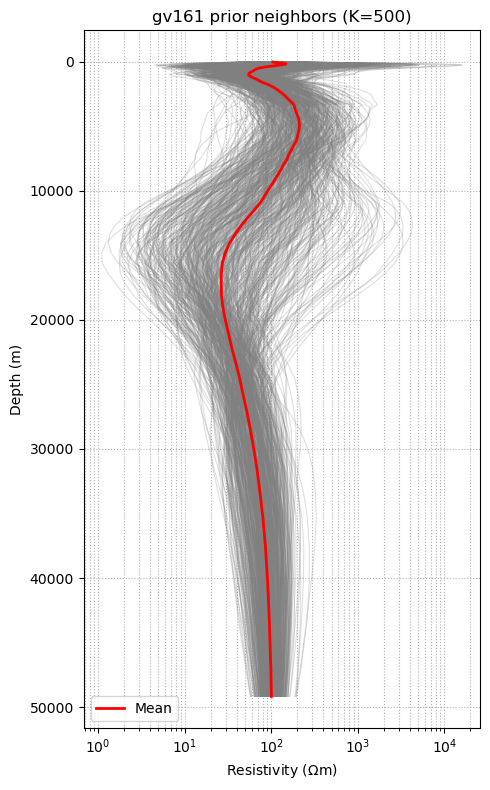

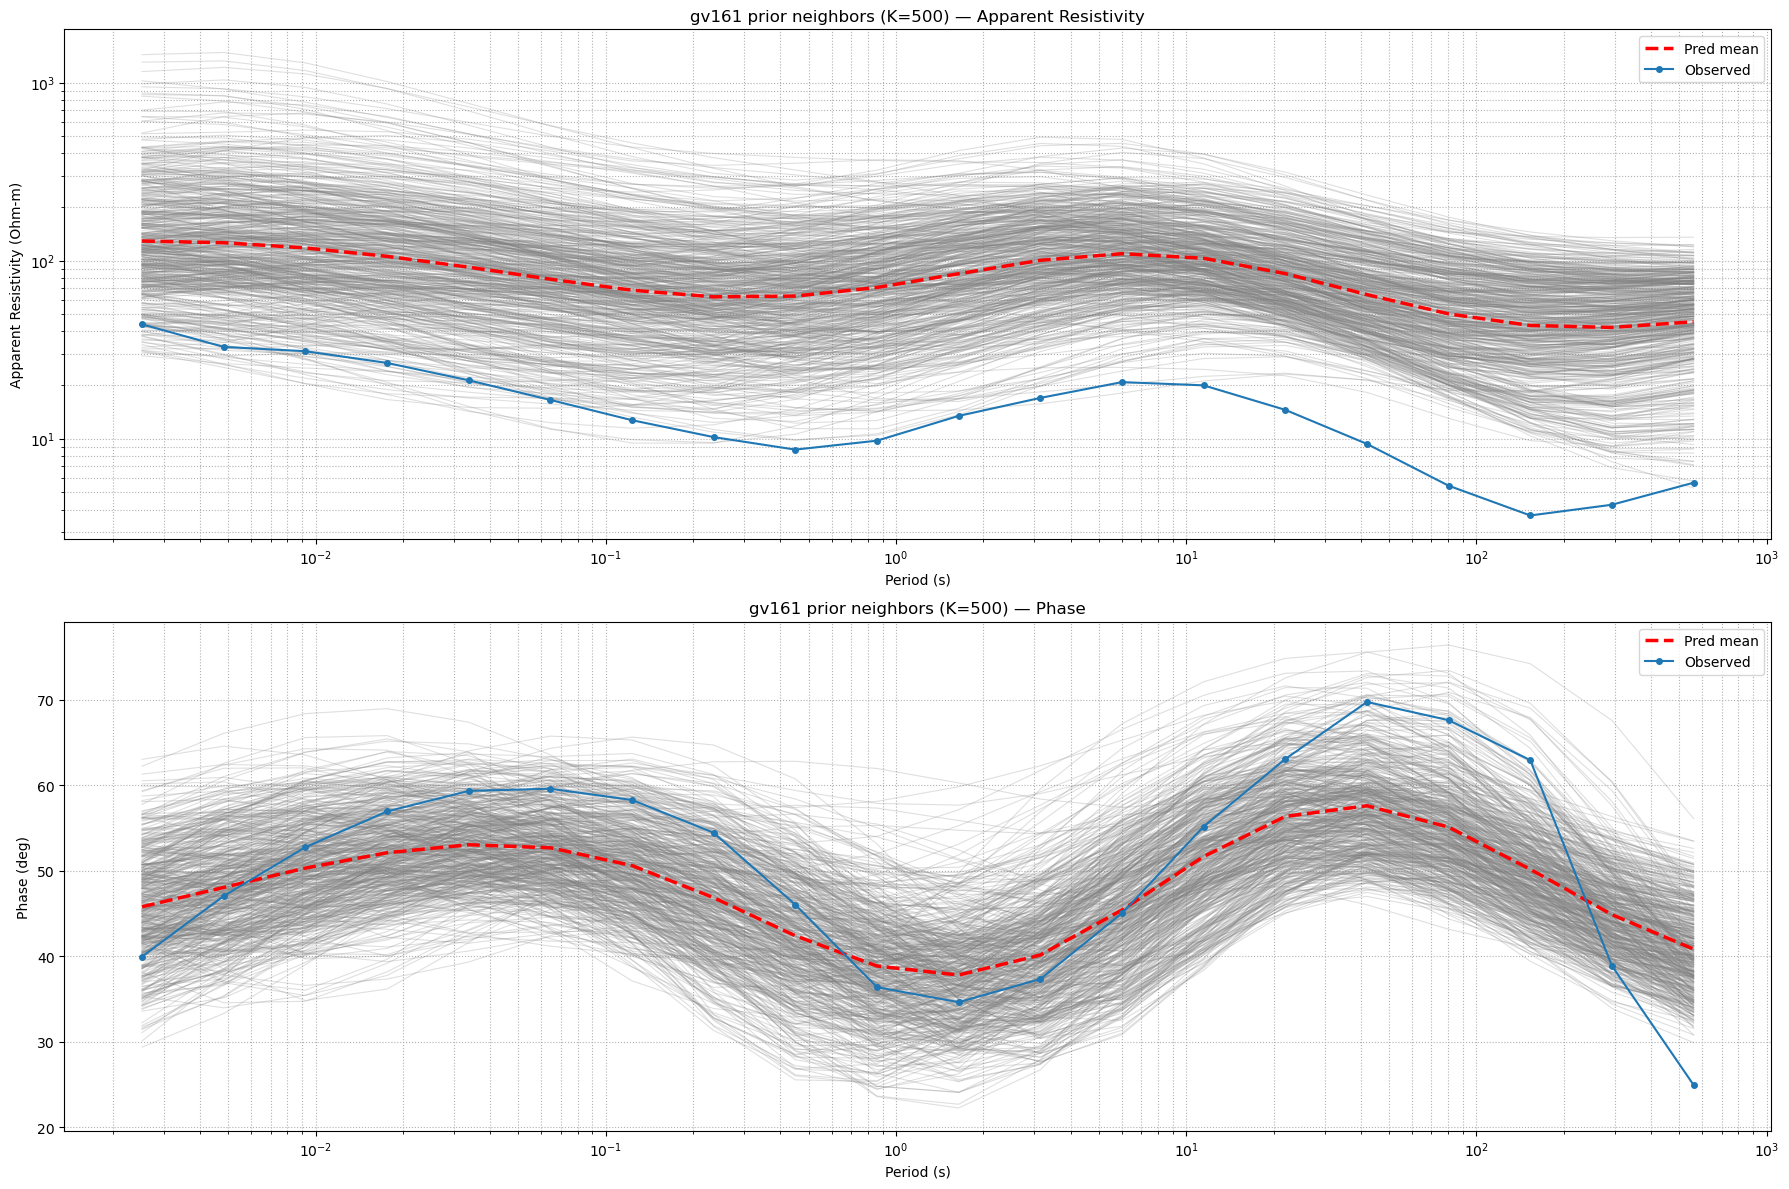

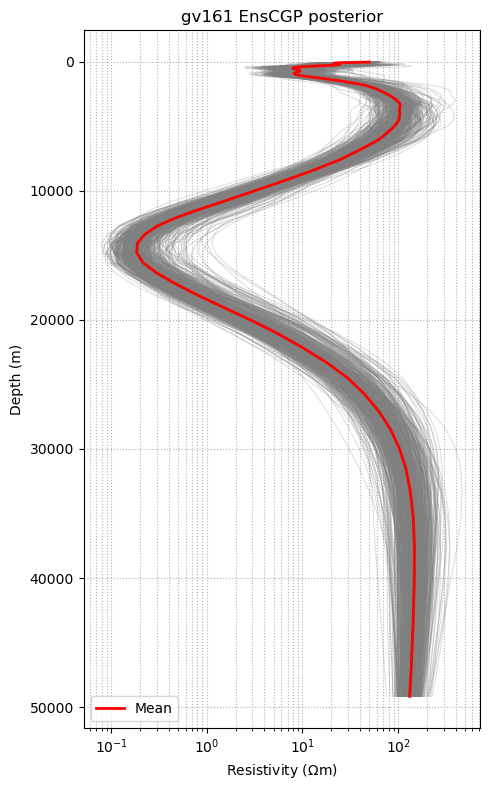

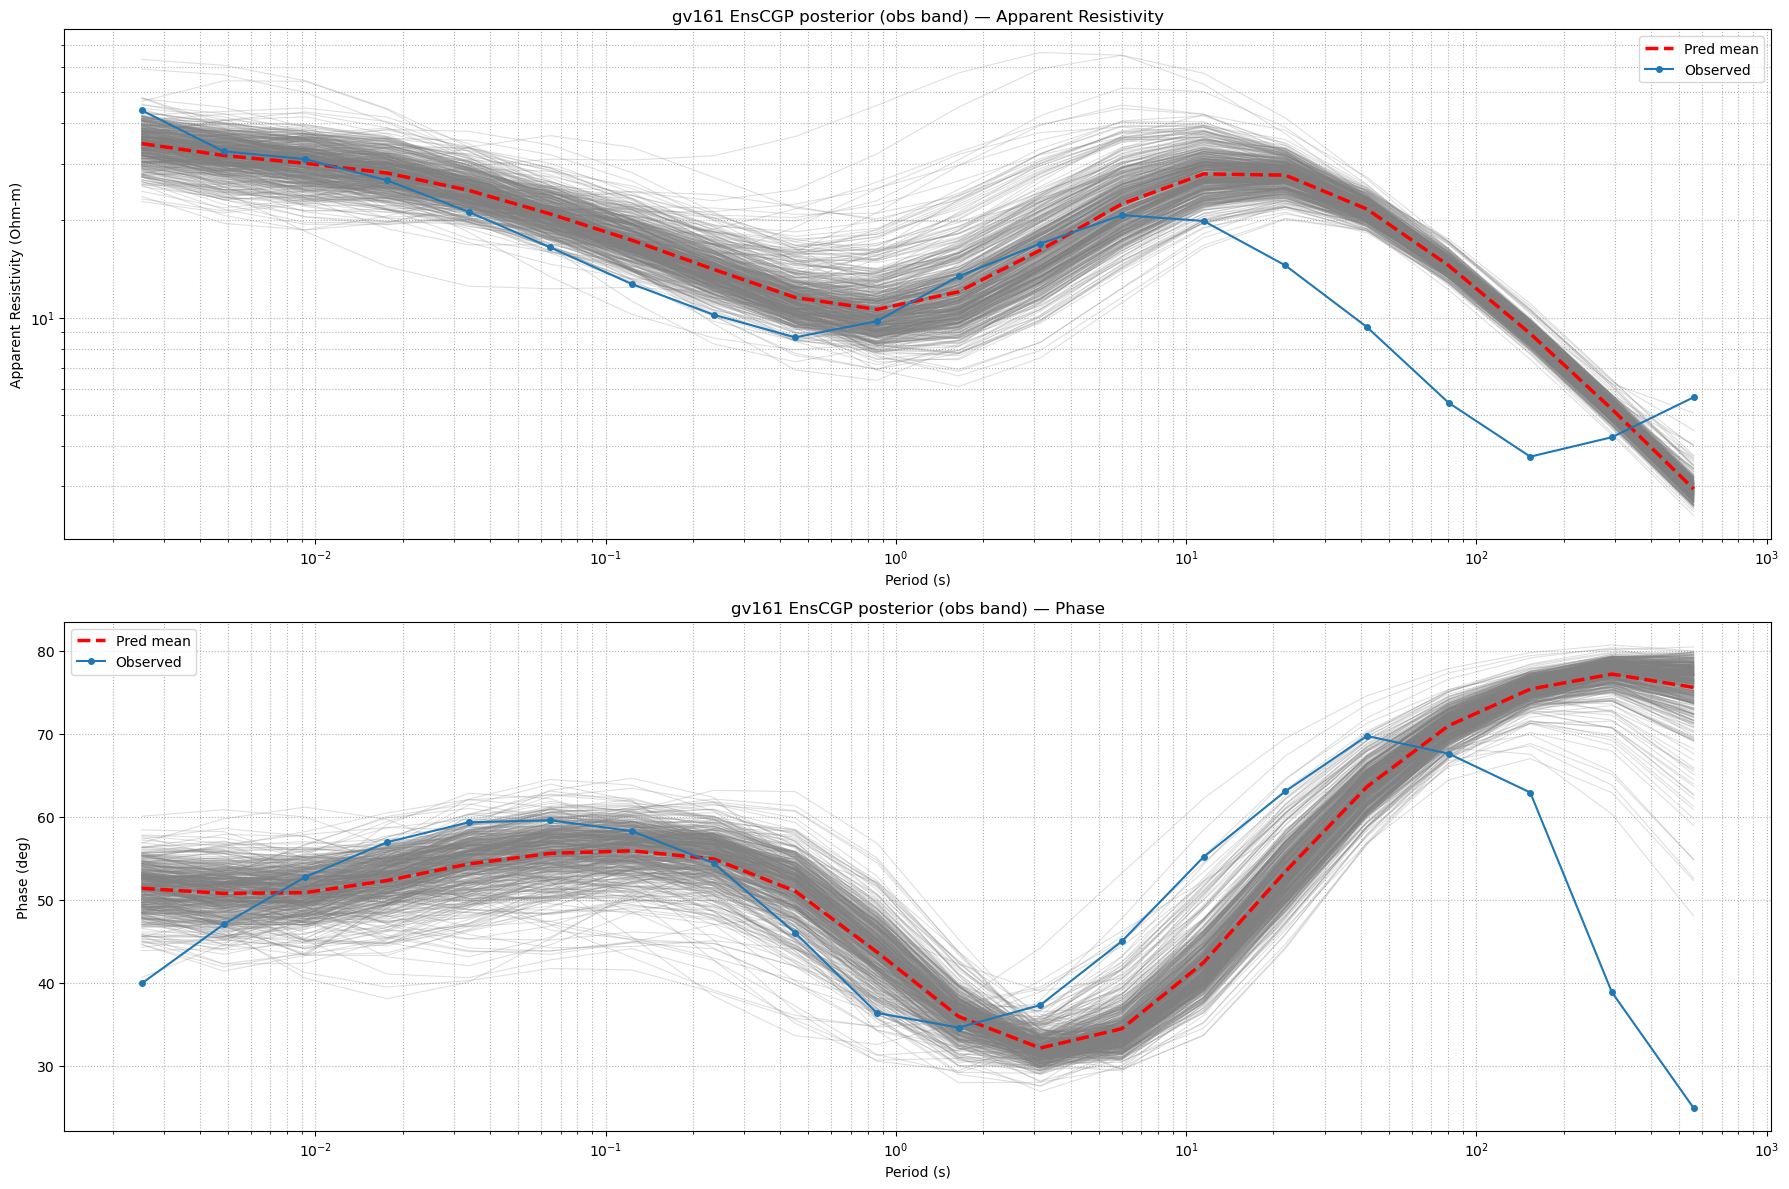

In [10]:
# --- Prior neighbors ---
idx = result.neighbor_indices
log_rho_nei = ens_on_obs.log_rho[:, idx]
log_app_nei = ens_on_obs.log_app_res[:, idx]
ph_nei = ens_on_obs.phase_deg[:, idx]

plot_resistivity_ensemble(
    log_rho_nei,
    depths_m,
    title=f'gv161 prior neighbors (K={idx.size})',
    savepath=out_dir / 'prior_neighbors_resistivity.png'
)

plot_mt_ensemble(
    periods_obs,
    log_app_nei,
    ph_nei,
    obs.log_app_res,
    obs.phase_deg,
    title=f'gv161 prior neighbors (K={idx.size})',
    savepath=out_dir / 'prior_neighbors_mt_obs_band.png'
)

# --- Posterior ---
plot_resistivity_ensemble(
    result.log_rho_updated,
    depths_m,
    title='gv161 EnsCGP posterior',
    savepath=out_dir / 'posterior_resistivity.png'
)

plot_mt_ensemble(
    periods_obs,
    result.log_app_res_updated,
    result.phase_deg_updated,
    obs.log_app_res,
    obs.phase_deg,
    title='gv161 EnsCGP posterior (obs band)',
    savepath=out_dir / 'posterior_mt_obs_band.png'
)


## 9) Compute and print nRMS misfit (mean prediction, whitened)

In [11]:
# --- nRMS (mean posterior prediction on observed grid) ---
sigma_log_rhoa = noise.app_res_log_sigma * np.ones_like(obs.log_app_res, dtype=np.float64)
sigma_phi_deg  = noise.phase_deg_sigma  * np.ones_like(obs.phase_deg, dtype=np.float64)

mean_log_app = np.mean(result.log_app_res_updated, axis=1)
mean_phi = np.mean(result.phase_deg_updated, axis=1)

r_app = (obs.log_app_res - mean_log_app) / sigma_log_rhoa
r_phi = (obs.phase_deg  - mean_phi)     / sigma_phi_deg

nrms = np.sqrt(np.mean(np.concatenate([r_app, r_phi])**2))
print('Computed nRMS:', nrms)


Computed nRMS: 4.97632233283284


## 10) Save outputs

In [12]:
# --- Save outputs ---
# Posterior resistivity
# np.savetxt(out_dir / 'gv161_enscgp_logrho_ens.txt', result.log_rho_updated)
np.savetxt(out_dir / 'gv161_enscgp_rho_ens_ohm_m.txt', np.exp(result.log_rho_updated))

# Obs-band predicted responses
# np.savetxt(out_dir / 'gv161_enscgp_logappres_obs_ens.txt', result.log_app_res_updated)
np.savetxt(out_dir / 'gv161_enscgp_appres_obs_ens_ohm_m.txt', np.exp(result.log_app_res_updated))
np.savetxt(out_dir / 'gv161_enscgp_phase_obs_ens_deg.txt', result.phase_deg_updated)

# Training-band predicted responses (for NPI input)
# np.savetxt(out_dir / 'gv161_enscgp_logappres_train_ens.txt', log_app_train)
np.savetxt(out_dir / 'gv161_enscgp_appres_train_ens_ohm_m.txt', np.exp(log_app_train))
np.savetxt(out_dir / 'gv161_enscgp_phase_train_ens_deg.txt', ph_train)

# # Means (optional convenience)
# np.savetxt(out_dir / 'gv161_enscgp_logrho_mean.txt', np.mean(result.log_rho_updated, axis=1))
# np.savetxt(out_dir / 'gv161_enscgp_rho_mean_ohm_m.txt', np.exp(np.mean(result.log_rho_updated, axis=1)))

# np.savetxt(out_dir / 'gv161_enscgp_logappres_obs_mean.txt', np.mean(result.log_app_res_updated, axis=1))
# np.savetxt(out_dir / 'gv161_enscgp_phase_obs_mean_deg.txt', np.mean(result.phase_deg_updated, axis=1))

# np.savetxt(out_dir / 'gv161_enscgp_logappres_train_mean.txt', np.mean(log_app_train, axis=1))
# np.savetxt(out_dir / 'gv161_enscgp_phase_train_mean_deg.txt', np.mean(ph_train, axis=1))

np.savetxt(out_dir / 'gv161_train_freqs_hz.txt', freqs_train)

print('Saved outputs to:', out_dir)


Saved outputs to: /mnt/c/Users/jdkim/Documents/Research_Projects/1D_NPI/synt_1d_gabbs/mt_example_gabbs_valley/1d_final/synt_training_final/npi-mt/outputs/enscgp/gv161


## 11) Next step: feed the pretrained ResNet

From this notebook you now have:

- `gv161_enscgp_logappres_train_ens.txt` and `gv161_enscgp_phase_train_ens_deg.txt`  
  → these are on the **training** grid and can be used as inputs to your pretrained ResNet.

